In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import random

path = os.getcwd().split(os.sep + 'GUI')[0]
if path not in sys.path:
    sys.path.append(path)

%load_ext autoreload
%autoreload 2

from neurolib.models.aln.timeIntegration import fast_interp2_opt, interpolate_values
from neurolib.models.aln import ALNModel
from neurolib.models import jacobian_aln as jac_aln

In [2]:
aln = ALNModel()

precalc_r = aln.params["precalc_r"]
dI = aln.params["dI"]
ds = aln.params["ds"]
sigmarange = aln.params["sigmarange"]
Irange = aln.params["Irange"]

In [200]:
def plot(time, state, target, u):
    fig, ax = plt.subplots(n_var+1,1, figsize=(10,12))
    for j in range(n_var):
        ax[j].plot(time, state[j,:])
    ax[0].plot(time, target[:], color='grey', linestyle='--')
    ax[-1].plot(time, u[:], color='red', label='control')
    
    plt.show()
    
def time_integration(x0, T, u, dt):
    time_steps_total = x0.shape[1] + np.around(T/dt, 0).astype(int)
        
    x = np.zeros(( n_var, time_steps_total ))
    x[:,:x0.shape[1]] = x0[:,:]
        
    if x0.shape[1] != delay+1:
        print("WARNING: initial state does not have correct length")
        
    for t in range(x0.shape[1], time_steps_total, 1):
        #s_dt = ( - x[2,t-1] + (1. - x[2,t-1]) * x[0,t-1-delay] ) / tau
        s_dt = ( - x[2,t-1] + ( 1. - x[2,t-1] ) * x[0,t-1-delay] ) / tau
        x[2,t] = x[2,t-1] + dt * s_dt
        mu_dt = ( x[2,t-1] + mu_ext - x[1,t-1] + u[t-1-delay]) / tau
        #mu_dt = ( mu_ext - x[1,t-1] + u[t-1-delay]) / tau
        x[1,t] = x[1,t-1] + dt * mu_dt
        sigma_dt =  ( 1. - x[2,t-1]**2 ) * x[0,t-1-delay] / tau**2
        x[3,t] = x[3,t-1] + dt * sigma_dt
        x[4,t] =  0.5 * ( x[3,t] + sigma_ext )
        x[0,t] = r_func(x[1,t-1], x[4,t-1])
                
    
    return x

In [201]:
tau = 10.
mu_ext = 1.
sigma_ext = 2.

x_shift_mu = - 2.
x_shift_sigma = -1.
x_scale_mu = 0.5
x_scale_sigma = 0.5
y_shift = 100.
y_scale_mu = 10.
y_scale_sigma = .1

global interpolate
interpolate = False

def r_func(mu, sigma):
    if interpolate:
        xid1, yid1, dxid, dyid = fast_interp2_opt(sigmarange, ds, sigma, Irange, dI, mu)
        xid1, yid1 = int(xid1), int(yid1)
        r_int = 1e3 * interpolate_values(precalc_r, xid1, yid1, dxid, dyid)
        return r_int
    #return mu + sigma
    else:
        return y_shift + mu**2 + sigma
        return (y_shift + np.tanh(x_scale_mu * mu + x_shift_mu) * y_scale_mu
                #+ sigma )
                + np.cosh(x_scale_sigma * sigma + x_shift_sigma) * y_scale_sigma )

def r_der_mu(mu, sigma):
    if interpolate:
        result = 1e3 * jac_aln.der_mu(sigma, sigmarange, ds, mu, Irange, dI, 1., precalc_r)
        return result
    #return 1.
    else:
        return 2. * mu
        return x_scale_mu * y_scale_mu / np.cosh(x_scale_mu * mu + x_shift_mu)**2

def r_der_sigma(mu, sigma):
    if interpolate:
        result = 1e3 * jac_aln.der_sigma(sigma, sigmarange, ds, mu, Irange, dI, 1., precalc_r)
        return result
    #return 1.
    else:
        return 1.
        return x_scale_sigma * y_scale_sigma / np.sinh(x_scale_sigma * sigma + x_shift_sigma)
    

global delay, dt
delay = 3
x0 = np.ones(( n_var,max(delay+1,1) ))
T = 200.
dt = 0.1
    
time = np.arange(0,T+dt, dt)
u0 = np.zeros(time.shape[0])
u0[1980] = 10.
x = time_integration(x0, T, u0, dt)
x0[:,:] = x[:,-delay-1:]
#print(x0)

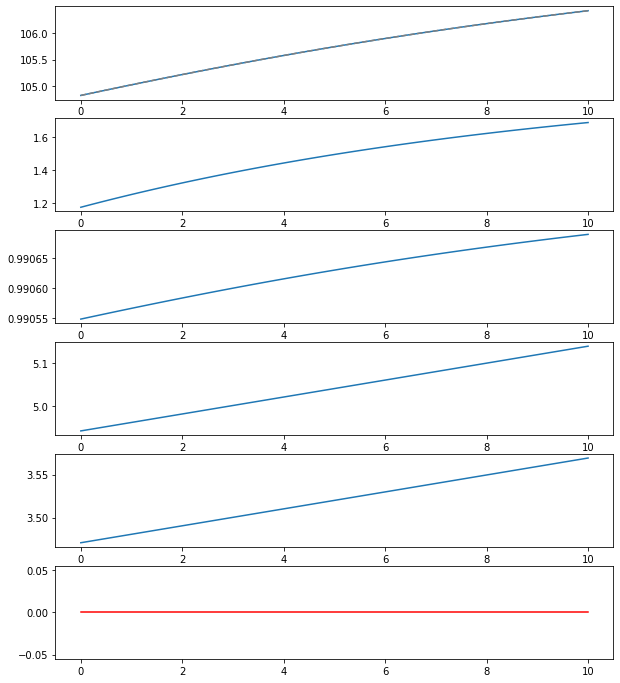

[104.82563563 104.84592934 104.86616449 104.88633898 104.90645081]
[1.17264687 1.18082589 1.18892314 1.19693943 1.20487558]
[3.47082865 3.4718147  3.47280075 3.4737868  3.47477285]


In [202]:
############# HOW TO APPROXIMATE TRANSFER FUNCTIONS?

delay = 0
x0 = np.ones(( n_var,max(delay+1,1) ))
T = 200.
dt = 0.1
    
time = np.arange(0,T+dt, dt)
u0 = np.zeros(time.shape[0])
u0[1000:1980] = -1.
x = time_integration(x0, T, u0, dt)
x0[:,:] = x[:,-delay-1:]

T = 10.
time = np.arange(0,T+dt, dt)
u0 = np.zeros(time.shape[0])
x = time_integration(x0, T, u0, dt)
state = x.copy()
target = state[0,delay:]

plot(time, state[:,delay:], target[:], u0)

print(state[0,:5])
print(state[1,:5])
print(state[4,:5])

2.4452937486462645
1.0000000000000853


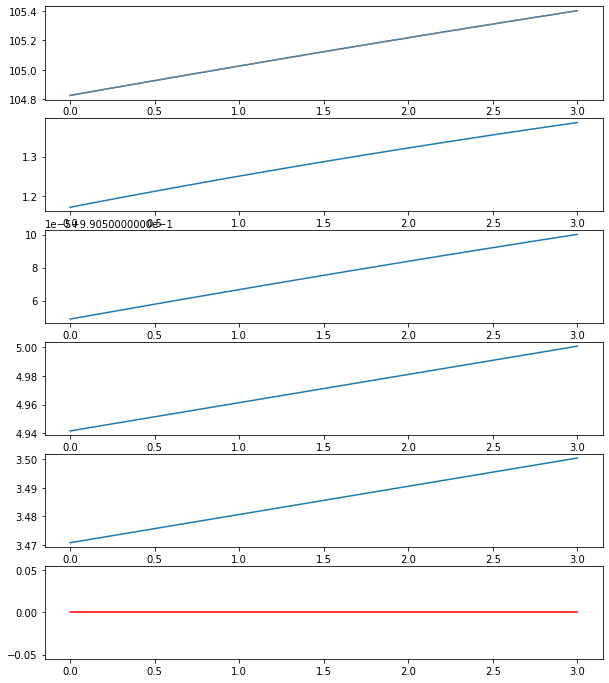

In [203]:
delay = 0
dt = 0.1
T = 30*dt

time = np.arange(0,T+dt, dt)
u0 = np.zeros(time.shape[0])
x = time_integration(x0, T, u0, dt)
state = x.copy()
target = state[0]

dx = 0.1
x0_ = x0.copy()
x0_[1] += dx
x_ = time_integration(x0_, T, u0, dt)
print( (x_[0,1] - x[0,1]) / dx)

x0_ = x0.copy()
x0_[4] += dx
x_ = time_integration(x0_, T, u0, dt)
print( (x_[0,1] - x[0,1]) / dx)

plot(time, state[:,delay:], target[:], u0)

In [204]:
mu = state[1,delay:]
sigma = state[4,delay:]
r = state[0,delay:]

In [205]:
t_start = 10

#mu = np.array( [1.9, 1.91, 1.93, 1.94, 1.96, 1.97, 1.99, 2., 2.02, 2.03, 2.04, 2.06] )
#sigma = np.array( [1.9, 1.92, 1.93, 1.95, 1.96, 1.98, 1.99, 2.01, 2.02, 2.04, 2.05, 2.06] )
#r = r_func(mu, sigma)

d_r = np.zeros((r.shape[0]-1))
d_mu = d_r.copy()
d_sigma = d_r.copy()

for t in range(d_r.shape[0]):
    d_r[t] = ( r[t+1] - r[t] ) / dt
    d_mu[t] = ( mu[t+1] - mu[t] ) / dt
    d_sigma[t] = ( sigma[t+1] - sigma[t] ) / dt

der_list_mu = []
der_list_sigma = []

mu_diff = mu[:] - mu[t_start]
sigma_diff = sigma[:] - sigma[t_start]
r_diff = r[:] - r[t_start]
c_global = r[t_start]

def fit_func(data_tuple, a, b):
    (x, y) = data_tuple
    return a*x + b*y + c_global

def fit_func_no_const(data_tuple, a, b):
    (x, y) = data_tuple
    return a*x + b*y

def fit_func_quad(data_tuple, a0, b0, a1, b1):
    (x, y) = data_tuple
    return a0*x + b0*y + a1*x**2 + b1*y**2 + c_global

print('actual derivatives:')
for t in range(mu.shape[0]):
    if t in [0,1,2]:
        print(t, mu[t], sigma[t], r[t], r_der_mu(mu[t], sigma[t]), r_der_sigma(mu[t], sigma[t]))
    if t in np.arange(t_start-3, t_start+3,1):
        print(t, mu[t], sigma[t], r[t], r_der_mu(mu[t], sigma[t]), r_der_sigma(mu[t], sigma[t]))
    der_list_mu.append( r_der_mu(mu[t], sigma[t]) )
    der_list_sigma.append( r_der_sigma(mu[t], sigma[t]) )
    
#print('mean values : ', np.mean(der_list_mu), np.mean(der_list_sigma))

n_data_list = [3,4,5,8,10,20]
est = [1., 1.]
est_quad = [0., 0., 0., 0.]
method_list = ['lm', 'trf', 'dogbox']

for method_ in method_list:
    print('-----------------', method_)
    for n_data in n_data_list:
        i1 = int(max(t_start-n_data/2+1,0))
        i2 = int(max(t_start-n_data/2+1,0)+n_data)
        print(n_data, i1, i2, len(mu_diff[i1:i2]))
        popt, pcov = opt.curve_fit(fit_func_no_const, (mu_diff[i1:i2], sigma_diff[i1:i2]), r_diff[i1:i2], p0=est, 
                                   method=method_)
        print('fit paramters linear difference: ', popt)
        popt, pcov = opt.curve_fit(fit_func_no_const, (d_mu[i1:i2], d_sigma[i1:i2]), d_r[i1:i2], p0=est, 
                                   method=method_)
        print('fit paramters from derivatives: ', popt)
        if n_data >=5:
            popt, pcov = opt.curve_fit(fit_func_quad, (mu[i1:i2], sigma[i1:i2]), r[i1:i2], p0=est_quad, 
                                       method=method_)
        print('fit paramters quad: ', popt)

actual derivatives:
0 1.1726468743231144 3.4708286467158604 104.82563562772829 2.345293748646229 1.0
1 1.1808258933433962 3.4718146954344062 104.84592933857563 2.3616517866867923 1.0
2 1.1889231403484835 3.472800746290241 104.86616448582463 2.377846280696967 1.0
7 1.2282111288059168 3.477731031693107 104.96639119115395 2.4564222576118335 1.0
8 1.235834631236695 3.478717094817043 104.98623360861582 2.47166926247339 1.0
9 1.243381916379093 3.479703159896833 105.00600433058098 2.486763832758186 1.0
10 1.2508537463368727 3.4806892269081335 105.02570174987538 2.5017074926737455 1.0
11 1.2582508755913484 3.481675295826976 105.04532432163313 2.516501751182697 1.0
12 1.2655740510776685 3.482661366629758 105.06487056175337 2.531148102155337 1.0
----------------- lm
3 9 12 3
fit paramters linear difference:  [ 1.00228178 12.38104521]
fit paramters from derivatives:  [ 1.01727131 12.26784078]
fit paramters quad:  [ 1.01727131 12.26784078]
4 9 13 4
fit paramters linear difference:  [ 1.01317172 12

In [116]:
print(r[:5])
print(mu[:5])
print(sigma[:5])

def r_anal(mu, sigma, mu_, sigma_):
    drmu = r_der_mu(mu, sigma)
    drsigma = r_der_sigma(mu, sigma)
    r = r_func(mu, sigma) 
    const = r + drmu * (-mu) + drsigma * (-sigma)
    return const + ( drmu * mu_ + drsigma * sigma_ ), const


for k in [t_start+1,t_start+2,t_start+3,t_start+4]:
    r_, c_ = r_anal(mu[t_start], sigma[t_start], mu[k], sigma[k])
    r_fit = fit_func( (mu[k], sigma[k]), popt[0], popt[1], popt[-1] )
    print(k, c_)
    print(r[k], r_, r[k]-r_)
    print(r[k], r_fit, r[k]-r_fit)

[91.24394833 91.24394842 91.24394851 91.24394859 91.24394868]
[1.17127587 1.17127595 1.17127603 1.17127611 1.17127619]
[3.46669647 3.46669648 3.46669649 3.4666965  3.46669651]
11 89.7934847378367
91.24394928635759 91.24394928657789 -2.2029666979506146e-10
91.24394928635759 92.4869452754475 -1.2429959890899056
12 89.7934847378367
91.24394937292178 91.24394937336234 -4.405649178806925e-10
91.24394937292178 92.48694536201148 -1.2429959890897067
13 89.7934847378367
91.24394945948596 91.2439494601468 -6.608331659663236e-10
91.24394945948596 92.48694544857545 -1.2429959890894935
14 89.7934847378367
91.24394954605015 91.24394954693123 -8.810872031972394e-10
91.24394954605015 92.48694553513943 -1.2429959890892803


In [154]:
105.51-7.2-1.9

96.41

In [119]:
import scipy.optimize as opt

def fit_func(data_tuple, a, b, c):
    (x, y) = data_tuple
    return a*x + b*y + c

def fit_func_no_const(data_tuple, a, b):
    (x, y) = data_tuple
    return a*x + b*y

def fit_func_quad(data_tuple, a0, b0, a1, b1, c):
    (x, y) = data_tuple
    return a0*x + b0*y + a1*x**2 + b1*y**2 + c